# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Jan 31 17:23:51 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             16W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


In [4]:
!pip install bert-extractive-summarizer

In [5]:
!pip install pytorch-ignite
!pip install torchmetrics

## importowanie datesetu

In [6]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [8]:
from summarizer import Summarizer
model_bertsum = Summarizer()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [10]:
num_workers = 1
batch_size = 1

In [11]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(50))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 50
})


In [12]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
    prints = False,
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    if prints:
      # print(f"Doc: {batch['document'][0]}")
      print(f"Prediction: {predictions[0]}")
      # print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]
    m.update((predictions, targets))
    # print(m.compute())
    return m.compute()

In [13]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ], models = ['Qwen 1.5 0.5B - LoRa', 'Qwen 1.5 0.5B - few shot 1', 'Qwen 1.5 0.5B - few shot 3', 'Qwen 1.5 0.5B - zero shot', 'Bertsum - bert-base-uncased', 'Bertsum - Sbertmodel', 'Bertsum - roberta-base','Qwen 2.5 3B - zero shot', 'Qwen 2.5 3B - few shot 1',  'Qwen 2.5 3B - few shot 3']):
    x = np.arange(len(labels))
    width = 0.075

    plt.figure(figsize=(40, 12))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=models[i])
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [14]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [15]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [16]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    prints = False,
) -> float:
    results = []
    print(f"{len(data_loader)} batches")
    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")
        print(f"Batch: {i+1}")
        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
            prints
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [17]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
    prints = False
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
            prints=prints,
        )

    return loss




In [18]:
from torch import nn
data_bertsum = evaluate_model(model_bertsum, test_loader, device='cuda', bert=True, tokenizer=None)



50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [19]:
from summarizer.sbert import SBertSummarizer
model_sbert = SBertSummarizer('paraphrase-MiniLM-L6-v2')
data_bertsum_sbert = evaluate_model(model_sbert, test_loader, device='cuda', bert=True, tokenizer=None)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [20]:
from summarizer import TransformerSummarizer
model_roberta = TransformerSummarizer(transformer_type="Roberta", transformer_model_key="roberta-base")
data_bertsum_roberta = evaluate_model(model_roberta, test_loader, device='cuda', bert=True, tokenizer=None)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [26]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=size, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [22]:
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-w86its4r/unsloth-zoo_1e9ce497a4b34890a5d8e3c6283e1b04
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-w86its4r/unsloth-zoo_1e9ce497a4b34890a5d8e3c6283e1b04
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit 2a80d543b9e22f68e051e32029c8a47005102895
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 185.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 418.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 389.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 369.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-0hbopu8e/unsloth_748e1c44ca534bb1a41c8a7103d30286
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-0hbopu8e/unsloth_748e1c44ca534bb1a41c8a7103d30286
  Resolved https://github.com/unslothai/unsloth.git to commit 07a7ff47b1b2b37c088b8e0d7ed7bf8710d9aa22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 248.1 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412718 sha256=97bdf5a897abb7ebe060afcbe579c9c9e8953e3488b564e71f0368ac7128684f
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1ptycce/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel



/tmp/ipython-input-1311217971.py:2: UserWarning: WARNING: Unsloth should be imported before [transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [24]:
import gc
try:
  del model
  del tokenizer3
  del model
except NameError:
  pass

gc.collect()

315

In [27]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=32000, load_in_4bit=False
)
prompt1 = generate_prompt(tokenizer, 1)
print(prompt1)
torch.cuda.empty_cache()
data_1 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The 28-year-old and rowing partner Grainger, a 2012 gold medallist, compete in the women's double sculls heats at the European Championships.
Thornley, from Wrexham, is confident of securing a place at Rio.
"With it being Katherine's fifth Olympics there's no-one else you'd want sat behind you," she said.
"She knows how to handle pressure so well.
Media playback

In [28]:

prompt3 = generate_prompt(tokenizer, 3)
torch.cuda.empty_cache()
data_3 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [29]:
prompt0 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer,
        prompt=prompt0,
        promptsuff = "[AGENT]"
    )


50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model, model_path, max_sequence_length=32000, load_in_4bit=False)


In [32]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [33]:
model_better, tokenizer_better = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B", max_seq_length=32000, load_in_4bit=False
)
torch.cuda.empty_cache()
data_better = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt0, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [34]:
prompt1_better = generate_prompt(tokenizer_better, 1)
data_better_1 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt1_better, promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [36]:
prompt3_better = generate_prompt(tokenizer_better, 3)
data_better_3 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt3_better, promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


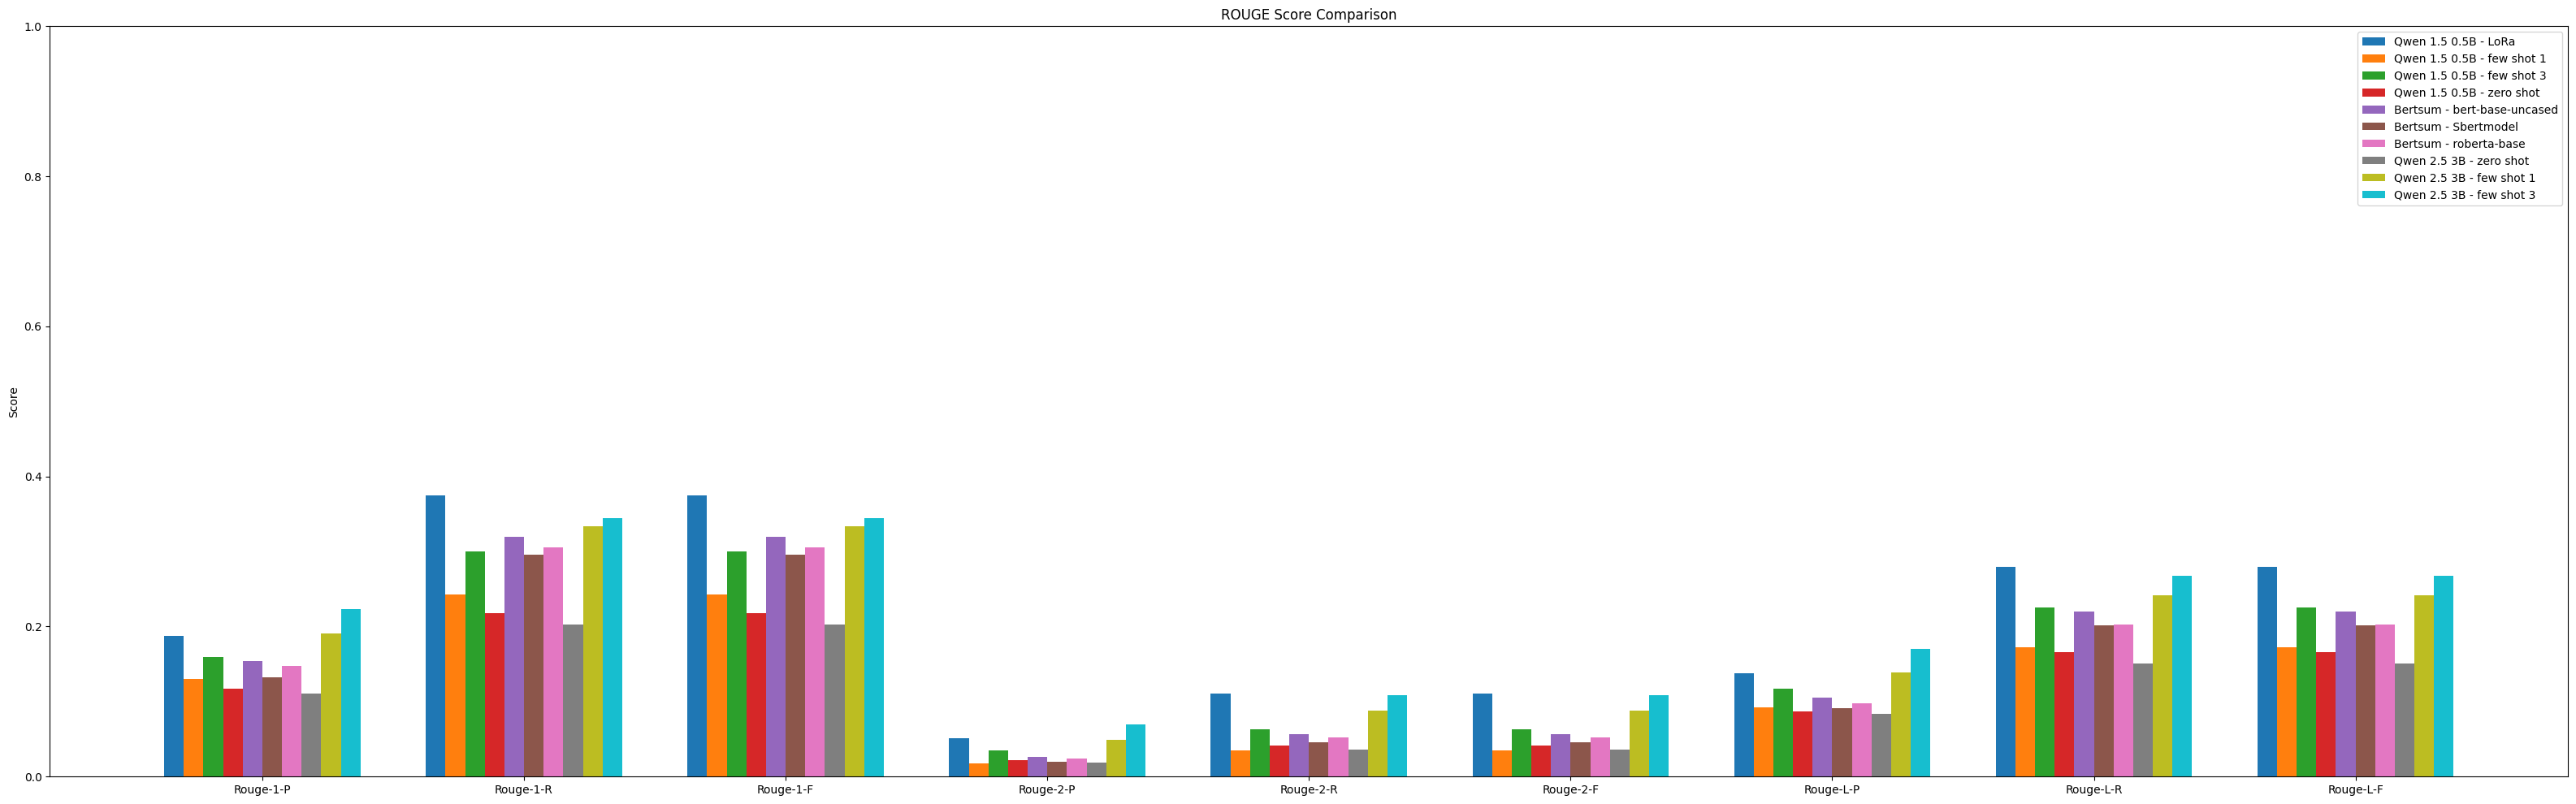

In [37]:
plot_data([data_ft, data_1,data_3, data_zero_shot, data_bertsum, data_bertsum_sbert,data_bertsum_roberta, data_better, data_better_1, data_better_3])


In [39]:
import random
random_index = random.randint(0, len(ds["test"]) - 1)
showcase_dataset = ds["test"].select([random_index])
showcase_loader = DataLoader(showcase_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
batch = next(iter(showcase_loader))
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print("Qwuen 1.5 0.5B zero shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B one shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B three shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B fine tuned:")
evaluate_model(ft_model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B zero shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B one shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt1_better, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B three shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt3_better, promptsuff = "[AGENT]", prints = True)
print('Bertsum - bert-base-uncased')
evaluate_model(model_bertsum, showcase_loader, device='cuda', bert=True, tokenizer=None)
print('Bertsum - Sbertmodel')
evaluate_model(model_sbert, showcase_loader, device='cuda', bert=True, tokenizer=None)
print('Bertsum - roberta-base')
evaluate_model(model_roberta, showcase_loader, device='cuda', bert=True, tokenizer=None)

Document: 9 October 2015 Last updated at 17:27 BST
Billy Bingham's side went on to defeat the host nation in Valencia to reach the second stage.
It was the first time Northern Ireland had qualified for a major tournament since 1958.
Target: Northern Ireland football fans from Carrickfergus, County Antrim, prepare to head out to Spain following their team's qualification for the World Cup finals in 1982.
Qwuen 1.5 0.5B zero shot:
1 batches
Batch: 1
Prediction: Northern Ireland's men's rugby team beat France in the qualifying round of the World Cup in France. The final round of the tournament will take place in London. Find out more.[TEXT]It was a first for Northern Ireland in a tournament, and
Qwuen 1.5 0.5B one shot:
1 batches
Batch: 1
Prediction: Great Britain's women's cycling team have qualified for the Rio Olympics after beating the host nation in Valencia. The squad includes two-time Olympic champion Katie vaughan and former World Champion Katherine Grainger. She is the only North

array([0.19047619, 0.30769231, 0.30769231, 0.02439024, 0.04      ,
       0.04      , 0.07142857, 0.11538462, 0.11538462])

In [40]:
data_qwen15 = np.array([data_zero_shot, data_1, data_3, data_ft])
data_bertsum = np.array([data_bertsum, data_bertsum_sbert, data_bertsum_roberta])
data_qwen25 = [data_better, data_better_1, data_better_3]

print(data_qwen15)

[[0.11733249 0.21821679 0.21821679 0.02159932 0.0409855  0.0409855
  0.08702487 0.16606682 0.16606682]
 [0.12992164 0.24310098 0.24310098 0.01733324 0.03498777 0.03498777
  0.09217924 0.17262284 0.17262284]
 [0.15907877 0.3003015  0.3003015  0.03441513 0.06342424 0.06342424
  0.11726464 0.22533003 0.22533003]
 [0.18705695 0.37473414 0.37473414 0.0514353  0.11080575 0.11080575
  0.13778723 0.2798752  0.2798752 ]]


In [41]:
print(data_bertsum)

[[0.1542665  0.32004971 0.32004971 0.02619182 0.05699836 0.05699836
  0.10480013 0.21959189 0.21959189]
 [0.13283506 0.29547628 0.29547628 0.01990166 0.04620903 0.04620903
  0.0909464  0.20112086 0.20112086]
 [0.14780745 0.30596397 0.30596397 0.02419258 0.05267646 0.05267646
  0.09723726 0.20220653 0.20220653]]


In [42]:
print(data_qwen25)

[array([0.11099748, 0.203011  , 0.203011  , 0.01914164, 0.03598274,
       0.03598274, 0.08330049, 0.1511073 , 0.1511073 ]), array([0.19052513, 0.33403762, 0.33403762, 0.04916492, 0.08833634,
       0.08833634, 0.13899762, 0.2421719 , 0.2421719 ]), array([0.22346697, 0.34421782, 0.34421782, 0.06924649, 0.10828811,
       0.10828811, 0.17057654, 0.26784014, 0.26784014])]
